In [51]:
import os
import cv2
import numpy as np
import random
from itertools import combinations
import matplotlib.pyplot as plt

In [52]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Lambda
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

In [53]:
# Fijar semilla
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [ ]:
IMG_SIZE = (200, 150) 
DATASET_DIR = "./resources"

In [55]:
def load_dataset(dataset_dir, size=IMG_SIZE):
    data = []
    labels = []
    person_dirs = sorted(os.listdir(dataset_dir))

    for idx, person in enumerate(person_dirs):
        person_path = os.path.join(dataset_dir, person)
        if os.path.isdir(person_path):
            images = []
            for fname in os.listdir(person_path):
                try:
                    fpath = os.path.join(person_path, fname)
                    img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
                    if img is None:
                        raise Exception("Imagen no válida")
                    img = cv2.resize(img, size)
                    img = img / 255.0
                    img = np.expand_dims(img, axis=-1)  # Añadir canal
                    images.append((img, idx, person))
                except Exception as e:
                    print(f"Error cargando {fpath}: {e}")
            if len(images) >= 2:
                data.append(images)
    return data

In [56]:
def generate_pairs(data, num_negatives_per_positive=1):
    pairs = []
    labels = []
    meta_info = []
    num_classes = len(data)

    for i, person_imgs in enumerate(data):
        for (img1, idx1, name1), (img2, idx2, name2) in combinations(person_imgs, 2):
            pairs.append([img1, img2])
            labels.append(1)
            meta_info.append(((idx1, name1), (idx2, name2)))

            for _ in range(num_negatives_per_positive):
                while True:
                    j = random.randint(0, num_classes - 1)
                    if j != i:
                        break
                img_neg, idx_neg, name_neg = random.choice(data[j])
                pairs.append([img1, img_neg])
                labels.append(0)
                meta_info.append(((idx1, name1), (idx_neg, name_neg)))

    return np.array(pairs), np.array(labels), meta_info


In [57]:
def show_pair(img1, img2, label, meta):
    (idx1, name1), (idx2, name2) = meta
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img1.squeeze(), cmap="gray")
    ax[0].set_title(f"{name1} (#{idx1})")
    ax[1].imshow(img2.squeeze(), cmap="gray")
    ax[1].set_title(f"{name2} (#{idx2})")
    plt.suptitle(f"Etiqueta: {'Iguales' if label == 1 else 'Diferentes'}")
    plt.show()

In [58]:
print("📂 Cargando dataset...")
data = load_dataset(DATASET_DIR)

print("🔧 Generando pares de entrenamiento...")
pairs, labels, meta_info = generate_pairs(data)

X1 = np.array([pair[0] for pair in pairs])
X2 = np.array([pair[1] for pair in pairs])
y = np.array(labels)

print(f"✅ Listo. Pares generados: {len(pairs)}")
print(f"X1 shape: {X1.shape}, X2 shape: {X2.shape}, y shape: {y.shape}")


📂 Cargando dataset...
🔧 Generando pares de entrenamiento...
✅ Listo. Pares generados: 200
X1 shape: (200, 150, 200, 1), X2 shape: (200, 150, 200, 1), y shape: (200,)


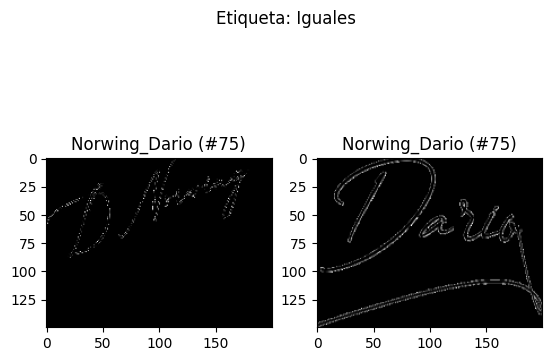

In [48]:
# Mostrar un ejemplo
i = random.randint(0, len(X1) - 1)
show_pair(X1[i], X2[i], y[i], meta_info[i])

In [59]:
def siamese_model(input_shape=(150, 200, 1)):  # alto, ancho, canal
    input_img = Input(input_shape)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    embedding = Dense(128)(x)
    return Model(inputs=input_img, outputs=embedding)

def euclidean_distance(vects):
    (feats1, feats2) = vects
    sum_squared = K.sum(K.square(feats1 - feats2), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_squared, K.epsilon()))


In [ ]:

base_model = siamese_model(input_shape=(150, 200, 1))  # Update input shape
input_a = Input(shape=(200, 150, 1))
input_b = Input(shape=(200, 150, 1))

embedding_a = base_model(input_a)
embedding_b = base_model(input_b)

distance = Lambda(euclidean_distance)([embedding_a, embedding_b])


ResourceExhaustedError: {{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:CPU:0}} OOM when allocating tensor with shape[1920000,128] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu [Op:AddV2] name: 

In [22]:
# Definir el modelo final
siamese_net = Model(inputs=[input_a, input_b], outputs=distance)

# Compilar el modelo
siamese_net.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

siamese_net.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 200, 150,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 200, 150,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 128)       │ 245,814,2… │ input_layer_4[0]… │
│ (Functional)        │                   │            │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ functional_1[0][… │
│                     │                   │            │ functional_1[1][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 245,814,208 (937.71 MB)

 Trainable params: 245,814,208 (937.71 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
print("X1 shape:", X1.shape)
print("X2 shape:", X2.shape)
print("y shape:", y.shape)
print("Ejemplo X1:", X1[0].shape)
print("Ejemplo X2:", X2[0].shape)


X1 shape: (200, 150, 200, 1)
X2 shape: (200, 150, 200, 1)
y shape: (200,)
Ejemplo X1: (150, 200, 1)
Ejemplo X2: (150, 200, 1)


In [23]:
# Entrenamiento
siamese_net.fit([X1, X2], y, batch_size=32, epochs=10, validation_split=0.2)

Epoch 1/10


ValueError: Input 0 of layer "functional_2" is incompatible with the layer: expected shape=(None, 200, 150, 1), found shape=(32, 150, 200)